In [39]:
#%matplotlib notebook
%matplotlib inline

# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,cfutil,glacier,gdalutil,shputil,pdutil
import uafgi.data.ns642
import netCDF4
import matplotlib.pyplot as plt
import uafgi.data.wkt
import uafgi.data.w21 as d_w21
map_wkt = uafgi.data.wkt.nsidc_ps_north
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pd.set_option("display.max_rows", 200, "display.max_columns", None)

from uafgi.data import d_velterm,d_sl19
import uafgi.data.stability as d_stability
import scipy

In [152]:
from uafgi.data import d_velterm

velterm_df = d_velterm.read()

In [40]:
    sl19 = d_sl19.read(map_wkt)


In [43]:
sl19.df.columns.tolist()

['sl19_termpos_L',
 'sl19_termpos_t',
 'sl19_termpos_source',
 'sl19_bjorkid',
 'sl19_rignotid',
 'sl19_lon',
 'sl19_lat',
 'sl19_x',
 'sl19_y',
 'sl19_dist2land',
 'sl19_rignotname',
 'sl19_RACMO_t',
 'sl19_RACMO_Q',
 'sl19_RACMO_tJJA',
 'sl19_RACMO_QJJA',
 'sl19_RACMO_Qbaseline',
 'sl19_EN4_TF',
 'sl19_EN4_t',
 'sl19_EN4_TFbaseline',
 'sl19_sector',
 'sl19_sectornum',
 'sl19_melt_t',
 'sl19_melt_m',
 'sl19_melt_meltbaseline',
 'sl19_MIROC5_RCP85_tTF',
 'sl19_MIROC5_RCP85_TF',
 'sl19_MIROC5_RCP85_bias_TF',
 'sl19_MIROC5_RCP85_tJJA',
 'sl19_MIROC5_RCP85_QJJA',
 'sl19_MIROC5_RCP85_bias_QJJA',
 'sl19_MIROC5_RCP85_tmelt',
 'sl19_MIROC5_RCP85_melt',
 'sl19_MIROC5_RCP26_tTF',
 'sl19_MIROC5_RCP26_TF',
 'sl19_MIROC5_RCP26_bias_TF',
 'sl19_MIROC5_RCP26_tJJA',
 'sl19_MIROC5_RCP26_QJJA',
 'sl19_MIROC5_RCP26_bias_QJJA',
 'sl19_MIROC5_RCP26_tmelt',
 'sl19_MIROC5_RCP26_melt',
 'sl19_NorESM_RCP85_tTF',
 'sl19_NorESM_RCP85_TF',
 'sl19_NorESM_RCP85_bias_TF',
 'sl19_NorESM_RCP85_tJJA',
 'sl19_NorESM_RC

In [2]:
select = pdutil.ExtDf.read_pickle(uafgi.data.join_outputs('stability', '01_select.dfx'))

In [78]:
select.df.w21_data_fname

0                    AP Bernstorff Data.nc
1                          Academy Data.nc
2                      Akullersuup Data.nc
3                    Akullikassaap Data.nc
4                  Akullikassaap E Data.nc
5                  Akullikassaap W Data.nc
6                      Alangorliup Data.nc
7                           Alison Data.nc
8            Anorituup Kangerlua N Data.nc
9                      Apuseerajik Data.nc
10                    CH Ostenfeld Data.nc
11                          Carlos Data.nc
12                        Carlos W Data.nc
13                    Christian IV Data.nc
14                         Cornell Data.nc
15                       Cornell N Data.nc
16                          Danell Data.nc
17                        Danell S Data.nc
18                 Daugaard Jensen Data.nc
19                  Deception O CN Data.nc
20                     Dietrichson Data.nc
21                    Docker Smith Data.nc
22                  Docker Smith E Data.nc
23         

In [224]:
select.df.iloc[11]  # Sample

w21t_Glacier                                                                     Carlos
w21t_date_termini                     [(2012-08-22 00:00:00, LINESTRING (-467434.086...
w21t_glacier_number                                                                 181
w21t_tloc                                 POINT (-465745.7177541752 -1403722.817399133)
w21_popular_name                                                             Carlos Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            NW
w21_category                                                                         DW
w21_Qr                                                                             2.21
w21_Qf                                                                             4.32
w21_Qm                                                                             1.72
w21_Qs                          

In [276]:
import scipy.stats
import scipy.interpolate
import sklearn.linear_model
import scipy.signal

binsize = 1
bins = np.arange(1960,2021,binsize)

def _binme(t,X,bins):
    return scipy.stats.binned_statistic(t,X, statistic='mean', bins=bins).statistic

def _bin_multi(bins, t_datas, detrend=False):
    """t_datas: [(X_t, X_data), (Y_t, Y_data), ...]
    """
    bbins = .5*(bins[:-1]+ bins[1:])
    mask_in = np.ones(len(bbins), dtype=bool)
    X_bs = list()
    for X_t, X_data in t_datas:
        X_b = _binme(X_t, X_data, bins)
        X_bs.append(X_b)
        mask_in = mask_in & ~np.isnan(X_b)

    X_bs = [X_b[mask_in] for X_b in X_bs]
    bbins = bbins[mask_in]
    if detrend:
        X_bs = [scipy.signal.detrend(X_b) for X_b in X_bs]

    return X_bs,bbins
        


def _binscat(X_t,X_data,Y_t,Y_data, bins, detrend=False):
    X_b = _binme(X_t, X_data, bins)
    Y_b = _binme(Y_t, Y_data, bins)
    bbins = .5*(bins[:-1]+ bins[1:])
    mask_in = ~np.isnan(X_b) & ~np.isnan(Y_b)

    # Use only data points where we all have data
    X_b = X_b[mask_in]
    Y_b = Y_b[mask_in]
    bbins = bbins[mask_in]
    
    # Detrend
    if detrend:
        X_b = scipy.signal.detrend(X_b)
        Y_b = scipy.signal.detrend(Y_b)

    X_sp = scipy.interpolate.UnivariateSpline(bbins,X_b)


    return X_b,Y_b,bbins,X_sp



ix = 11
selrow = select.df.iloc[ix]

In [310]:
selrow

w21t_Glacier                                                                     Carlos
w21t_date_termini                     [(2012-08-22 00:00:00, LINESTRING (-467434.086...
w21t_glacier_number                                                                 181
w21t_tloc                                 POINT (-465745.7177541752 -1403722.817399133)
w21_popular_name                                                             Carlos Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            NW
w21_category                                                                         DW
w21_Qr                                                                             2.21
w21_Qf                                                                             4.32
w21_Qm                                                                             1.72
w21_Qs                          

In [277]:
#### Wood et al + CALFIN dataset

glacier_id = selrow.w21t_glacier_number
glacier_df0 = velterm_df[velterm_df.glacier_id == glacier_id]

# ---------------------------------------------------
# Get rid of future termini
glacier_df = glacier_df0[glacier_df0.term_year < 2020]

# Useonly termini since 2000
df = glacier_df[
    (glacier_df['term_year'] > 2000) & (glacier_df.term_year < 2020)]

# Use only velocities older than the terminus
df = df[df.vel_year < df.term_year]

# Convert up_area to up_len_km
df['up_len_km'] = df['up_area'] / (selrow.w21_mean_fjord_width * 1e6)

glacier_df = df
# ---------------------------------------------------
yearlen = glacier_df.sort_values(['term_year'])[['term_year', 'up_len_km']].drop_duplicates()

Melt by year


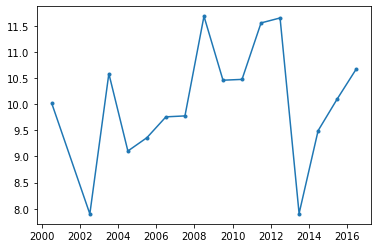

Slater termpos by year


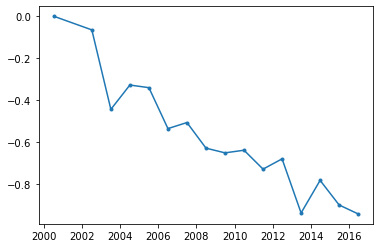

up_len_km (x) vs. Slater termpos (y)
LinregressResult(slope=0.8138581650833305, intercept=-7.30153912203654, rvalue=0.9544168216887197, pvalue=9.71676080028617e-09, stderr=0.06802327220897143, intercept_stderr=0.5631464062226852)


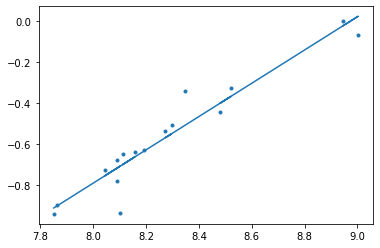

melt by Slater termpos
LinregressResult(slope=-0.06991085994049358, intercept=0.13230003367782583, rvalue=-0.283206116619902, pvalue=0.28783235287550063, stderr=0.0632737178186272, intercept_stderr=0.6384283224635487)


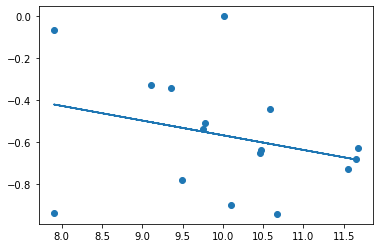

-0.06991085994049358

In [291]:
# Reproduce plots in Slater et al 2019 supplement

(melt_b,termpos_b,up_len_km_b),bbins = _bin_multi(bins, [
    (selrow.sl19_melt_t, selrow.sl19_melt_m),
    (selrow.sl19_termpos_t, selrow.sl19_termpos_L),
    (yearlen.term_year, yearlen.up_len_km)])

# Get correspondence between Slater and our terminus positions
# Allows prediction of termpos from up_len_km
termpos_lr = scipy.stats.linregress(up_len_km_b,termpos_b)


melt_sp = scipy.interpolate.UnivariateSpline(bbins,melt_b)

print('Melt by year')
plt.plot(bbins,melt_b, marker='.')
plt.show()

print('Slater termpos by year')
plt.plot(bbins,termpos_b, marker='.')
plt.show()

print('up_len_km (x) vs. Slater termpos (y)')
print(termpos_lr)
plt.scatter(up_len_km_b, termpos_b, marker='.')
plt.plot(up_len_km_b, termpos_lr.slope*up_len_km_b + termpos_lr.intercept)
plt.show()

print('melt by Slater termpos')
lr = scipy.stats.linregress(melt_b,termpos_b)
print(lr)
plt.scatter(melt_b,termpos_b)
plt.plot(melt_b,lr.slope*melt_b + lr.intercept)
plt.show()

lr.slope

In [297]:
# Carry over melt from Slater data
#m#elt_sp = selrow.melt_t, selrow.melt_m

w21t_Glacier                                                                     Carlos
w21t_date_termini                     [(2012-08-22 00:00:00, LINESTRING (-467434.086...
w21t_glacier_number                                                                 181
w21t_tloc                                 POINT (-465745.7177541752 -1403722.817399133)
w21_popular_name                                                             Carlos Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            NW
w21_category                                                                         DW
w21_Qr                                                                             2.21
w21_Qf                                                                             4.32
w21_Qm                                                                             1.72
w21_Qs                          

In [303]:
# Get melt from slater data
glacier_df['sl19_melt'] = glacier_df['term_year'].map(melt_sp)

# Predicted termpos based on Slater's relationship with melt
# lr = scipy.stats.linregress(melt_b,termpos_b)
glacier_df['sl19_pred_termpos'] = glacier_df['sl19_melt'] * lr.slope + lr.intercept

# Conversion of our up_len_km to Slater units (to use in melt vs. terminal position relation)
glacier_df['our_termpos'] = glacier_df['up_len_km'].map(lambda x: termpos_lr.slope*x + termpos_lr.intercept)

# Difference between our termpos and the predicted termpos
# This is the residual between Slater's prediction vs. what actually happened
glacier_df['termpos_residual'] = glacier_df['our_termpos'] - glacier_df['sl19_pred_termpos']



LinregressResult(slope=-1.3065226753221324e-05, intercept=2.750919853398438, rvalue=-0.8047856061382181, pvalue=3.250100355492284e-05, stderr=2.337120033677167e-06, intercept_stderr=0.4967493012673929)


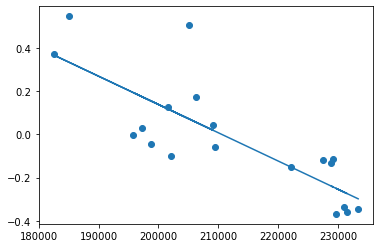

In [311]:
# See if there's a correlation between residuals on terminal position,
# and our computed sigma (based on fjord geometry)
df = glacier_df[['term_year', 'fluxratio', 'termpos_residual']].dropna().groupby('term_year').mean()
resid_lr = scipy.stats.linregress(df.fluxratio,df.termpos_residual)
print(resid_lr)
plt.scatter(df.fluxratio, df.termpos_residual)
plt.plot(df.fluxratio, df.fluxratio*resid_lr.slope + resid_lr.intercept)
plt.show()

In [222]:
for ix,grow in glacier_df.iterrows():
    melt = melt_sp(grow.term_year)
    # Predict slater terminus position based on melt
    slater_termpos = termpos_lr.slope * melt + lr.intercept

In [147]:
glacier_df0

,vel_year,future_index,term_year,terminus,aflux,sflux,ncells,up_area,fluxratio,glacier_id
0,1985.498516,NaN,1987.547831,None,0.000000,0.000000,66,94730000.0,NaN,22
1,1985.498516,NaN,1987.616324,None,0.000000,0.000000,70,93880000.0,NaN,22
2,1985.498516,NaN,1992.715733,None,0.000000,0.000000,70,95140000.0,NaN,22
3,1985.498516,NaN,1993.660160,None,0.000000,0.000000,70,95580000.0,NaN,22
4,1985.498516,NaN,1994.687557,None,0.000000,0.000000,70,95600000.0,NaN,22
...,...,...,...,...,...,...,...,...,...,...
1423,2018.498516,16.0,2036.000000,None,0.075050,11809.346558,22,20120000.0,157353.523477,22
1424,2018.498516,17.0,2037.000000,None,0.070797,14291.255146,29,17890000.0,201861.396051,22
1425,2018.498516,18.0,2038.000000,None,0.061266,10540.871005,37,14740000.0,172049.810679,22
1426,2018.498516,19.0,2039.000000,None,0.021513,3455.063072,29,12830000.0,160600.865823,22


In [148]:
selrow

w21t_Glacier                                                           Kangiata Nunaata
w21t_date_termini                     [(1996-08-13 00:00:00, LINESTRING (-231159 -28...
w21t_glacier_number                                                                  22
w21t_tloc                                 POINT (-228477.5918560606 -2819664.876893939)
w21_popular_name                                                   Kangiata Nunaata Se.
w21_greenlandic_name                                            Kangiata Nunaata Sermia
w21_coast                                                                            SW
w21_category                                                                         CR
w21_Qr                                                                             1.81
w21_Qf                                                                            -0.62
w21_Qm                                                                            -1.51
w21_Qs                          

In [149]:
# Get melt and prediction for each data point


array([1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010,
       2015, 2020])

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020])

In [312]:
lr

LinregressResult(slope=-0.06991085994049358, intercept=0.13230003367782583, rvalue=-0.283206116619902, pvalue=0.28783235287550063, stderr=0.0632737178186272, intercept_stderr=0.6384283224635487)

In [314]:
'{:2.0f}'.format(33.2424)

'33'

In [320]:
select.df.iloc[1]

w21t_Glacier                                                                    Academy
w21t_date_termini                     [(2019-03-24 00:00:00, LINESTRING (195411 -887...
w21t_glacier_number                                                                 142
w21t_tloc                                  POINT (198779.5673076923 -884887.2740384615)
w21_popular_name                                                            Academy Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                             N
w21_category                                                                         SR
w21_Qr                                                                             2.52
w21_Qf                                                                             0.34
w21_Qm                                                                              NaN
w21_Qs                          

In [317]:
import collections
NT = collections.namedtuple('NT', ('a','b'))
nt=  NT(1,4)
nt._asdict()

{'a': 1, 'b': 4}

In [318]:
slfit

NameError: name 'slfit' is not defined

In [321]:
select.df.sl19_rignotid.values

array([ 12.,  nan,  nan,  nan,  98.,  nan,  nan,  17.,  33.,  nan,  nan,
       118., 151.,  nan,  nan, 130., 108., 143.,   8.,  nan,  nan,  nan,
        nan,  89.,  90.,  nan,  nan,  nan,  nan,   7.,  nan,  nan,  nan,
        24.,  96.,  37., 116.,  nan,  nan,  nan,   3.,  nan,  43.,  45.,
        nan,  29.,  nan,  88.,  nan,  nan,   2.,  47.,  36.,  52.,  70.,
        nan,  nan,  nan,  14.,  nan,  nan,  13.,  nan, 152.,  65., 134.,
        60.,  31.,  23.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  55.,  85.,  nan,
        nan,  nan,  nan,  nan,   5.,  nan,  nan,  nan, 192., 171., 150.,
        53.,  53.,  25.,  nan, 119.,  nan,  nan, 154.,  nan,   6.,  nan,
        nan,  nan,  nan,  68.,  nan,  nan,  nan,  22.,  nan,  nan, 106.,
        10.,  nan,  nan])

In [331]:
pd.read_pickle('16_slfit.df').iloc[0]

bbins1              [2000.5, 2001.5, 2002.5, 2003.5, 2004.5, 2005....
termpos_b1          [1.85574705661388, 2.10500728217934, 0.2679392...
up_len_km_b1        [21.024324324324326, 21.13783783783784, 19.543...
bbins1l             [1990.5, 1994.5, 1997.5, 1999.5, 2000.5, 2001....
melt_b1l            [35.45408630371094, 31.908002853393555, 36.492...
termpos_b1l         [2.55154454210808, 3.27395964306857, 2.7513186...
bbins                [1992.5, 1997.5, 2002.5, 2007.5, 2012.5, 2017.5]
melt_b              [33.5391342163086, 36.837625122070314, 39.0436...
termpos_b           [2.912752092588325, 2.62931962180365, 0.593587...
termpos_lr          (1.003852129458044, -19.230307104434107, 0.994...
slater_lr           (-0.44787529871951826, 17.47082654200265, -0.7...
resid_lr            (3.053434214129611e-05, -8.602379538515368, 0....
term_year           [2000.6201047358834, 2001.5779680365297, 2002....
fluxratio           [243416.2371710083, 241467.0361929814, 287949....
termpos_residual    

In [332]:
lr

LinregressResult(slope=-0.06991085994049358, intercept=0.13230003367782583, rvalue=-0.283206116619902, pvalue=0.28783235287550063, stderr=0.0632737178186272, intercept_stderr=0.6384283224635487)

In [333]:
print('\u03C3')

σ


In [334]:
glacier_df

,vel_year,future_index,term_year,terminus,aflux,sflux,ncells,up_area,fluxratio,glacier_id,up_len_km,sl19_termpos,sl19_melt,sl19_pred_termpos,our_termpos,termpos_residual
20,1985.498516,NaN,2000.568192,None,9.929803e-08,0.009807,53,34710000.0,98763.625935,181,8.945876,-0.020865,9.405640,-0.525256,-0.020865,0.504392
21,1985.498516,NaN,2001.638242,None,3.101703e-07,0.007564,59,34100000.0,24387.222596,181,8.788660,-0.148817,9.324885,-0.519611,-0.148817,0.370794
22,1985.498516,NaN,2002.471119,None,3.598432e-08,0.001844,53,34930000.0,51257.847541,181,9.002577,0.025282,9.338708,-0.520577,0.025282,0.545859
23,1985.498516,NaN,2003.586187,None,0.000000e+00,0.000000,53,32900000.0,NaN,181,8.479381,-0.400525,9.440172,-0.527671,-0.400525,0.127145
24,1985.498516,NaN,2004.573657,None,0.000000e+00,0.000000,51,33060000.0,NaN,181,8.520619,-0.366964,9.588745,-0.538057,-0.366964,0.171093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,2016.499886,NaN,2019.188927,None,1.047297e-01,26205.485710,50,30810000.0,250220.097599,181,7.940722,-0.838918,8.948508,-0.493298,-0.838918,-0.345620
1925,2017.498516,NaN,2018.745091,None,9.410113e-02,23655.450543,47,30650000.0,251383.277869,181,7.899485,-0.872479,9.105682,-0.504286,-0.872479,-0.368193
1926,2017.498516,NaN,2019.188927,None,9.603131e-02,24441.485634,50,30810000.0,254515.804724,181,7.940722,-0.838918,8.948508,-0.493298,-0.838918,-0.345620
1984,2018.498516,NaN,2018.745091,None,8.966914e-02,22824.728890,47,30650000.0,254543.863262,181,7.899485,-0.872479,9.105682,-0.504286,-0.872479,-0.368193


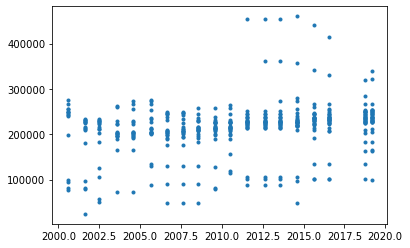

In [349]:
plt.plot(glacier_df.set_index('term_year')[['fluxratio']], marker='.', linestyle='none')
plt.show()

In [389]:
from uafgi import cptutil
import matplotlib
import matplotlib.cm

cmap,_,_ = cptutil.read_cpt('gay_flag_1978.cpt')
#cmap = matplotlib.cm.Greys_r
norm = matplotlib.colors.Normalize(vmin=1980, vmax=2000, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.to_rgba(2018)

(1.0, 0.4117647058823529, 0.7058823529411765, 1.0)

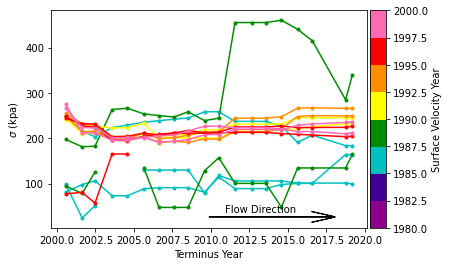

In [435]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

ax.set_xlabel('Terminus Year')
ax.set_ylabel('$\sigma$ (kpa)')

for vel_year,df in glacier_df.groupby('vel_year'):
    df['fluxratio'] = df['fluxratio'] / 1000.   # Convert to kPa
    if vel_year >= 2000:
        continue
    ax.plot(df.set_index('term_year')[['fluxratio']], marker='.', color=mapper.to_rgba(vel_year))
    
cb1 = matplotlib.colorbar.ColorbarBase(
    cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Surface Velocity Year')


#transform=ax.transAxes
arrow = ax.arrow(
    .5,.05,.4,0, transform=ax.transAxes,
    head_width=.05, fc='black', length_includes_head=True,
    shape='full', overhang=1,
    label='Direction of Ice Flow')
ax.annotate('Flow Direction', xy=(.55, .07), xycoords='axes fraction', size=10)
#ax.legend([arrow,], ['Hello'])
plt.show()

w21t_Glacier                                                                     Carlos
w21t_date_termini                     [(2012-08-22 00:00:00, LINESTRING (-467434.086...
w21t_glacier_number                                                                 181
w21t_tloc                                 POINT (-465745.7177541752 -1403722.817399133)
w21_popular_name                                                             Carlos Gl.
w21_greenlandic_name                                                                   
w21_coast                                                                            NW
w21_category                                                                         DW
w21_Qr                                                                             2.21
w21_Qf                                                                             4.32
w21_Qm                                                                             1.72
w21_Qs                          